# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK PRIOR TO CHANGING THE SELECTION OF TEST IMAGES PER USE CASE AS PROVIDED HYPER-PARAMETER VALUES CAN BE QUITE SENSITITVE TO EXAMPLE IMAGE YOU ARE USING.**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  c:\Users\jeann\Documents\Cours_Telecom\2A\IMA204--Telecom-Paris\TP\TP05


In [2]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  c:\Users\jeann\Documents\Cours_Telecom\2A\IMA204--Telecom-Paris\TP\TP05/data/abdominalCT\CTs1.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

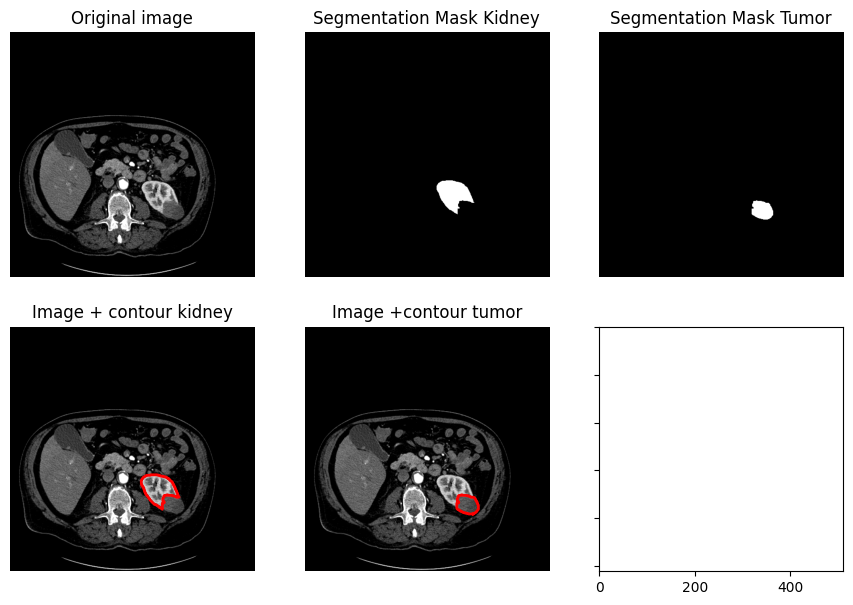

In [3]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['c:\\Users\\jeann\\Documents\\Cours_Telecom\\2A\\IMA204--Telecom-Paris\\TP\\TP05/data/brainMRI\\MRIs1-seg.png', 'c:\\Users\\jeann\\Documents\\Cours_Telecom\\2A\\IMA204--Telecom-Paris\\TP\\TP05/data/brainMRI\\MRIs2-seg.png', 'c:\\Users\\jeann\\Documents\\Cours_Telecom\\2A\\IMA204--Telecom-Paris\\TP\\TP05/data/brainMRI\\MRIs3-seg.png', 'c:\\Users\\jeann\\Documents\\Cours_Telecom\\2A\\IMA204--Telecom-Paris\\TP\\TP05/data/brainMRI\\MRIs4-seg.png']
Reading image  c:\Users\jeann\Documents\Cours_Telecom\2A\IMA204--Telecom-Paris\TP\TP05/data/brainMRI\MRIs2.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

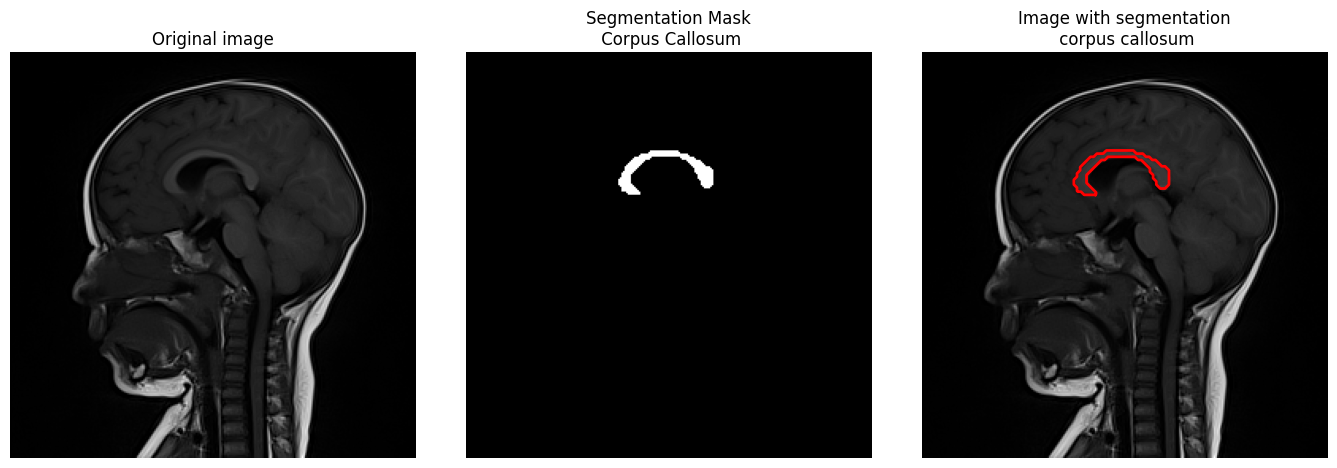

In [4]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 1 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value: [[-99999]]


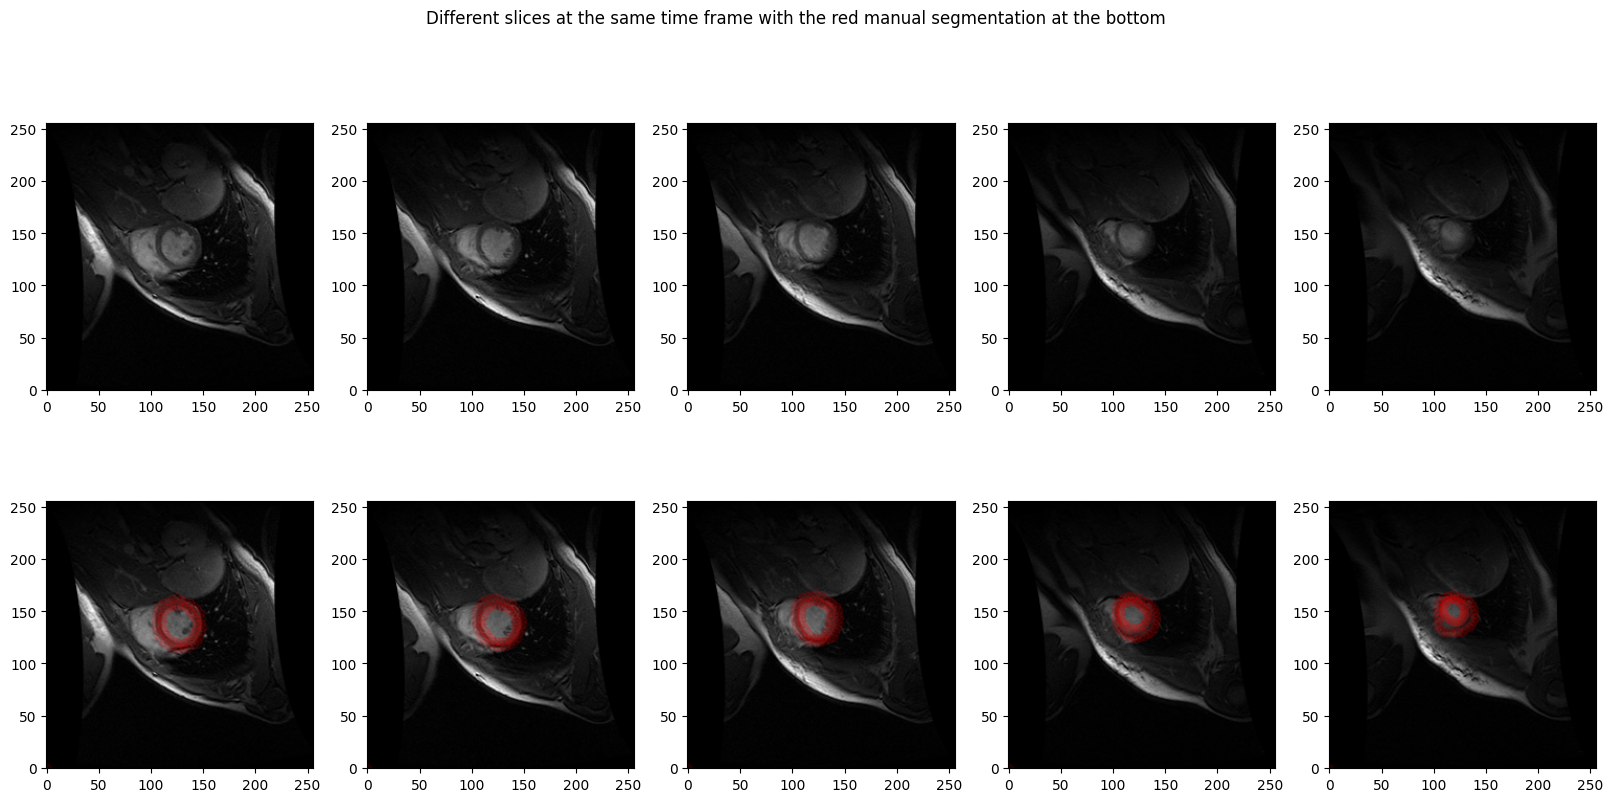

In [5]:

# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 8
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Different slices at the same time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1) 

## For cardiac MRI: how to create a binary mask from the provided contours

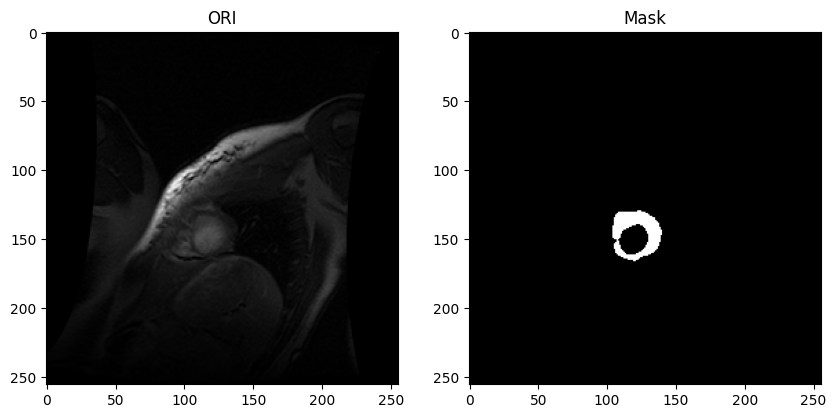

In [6]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



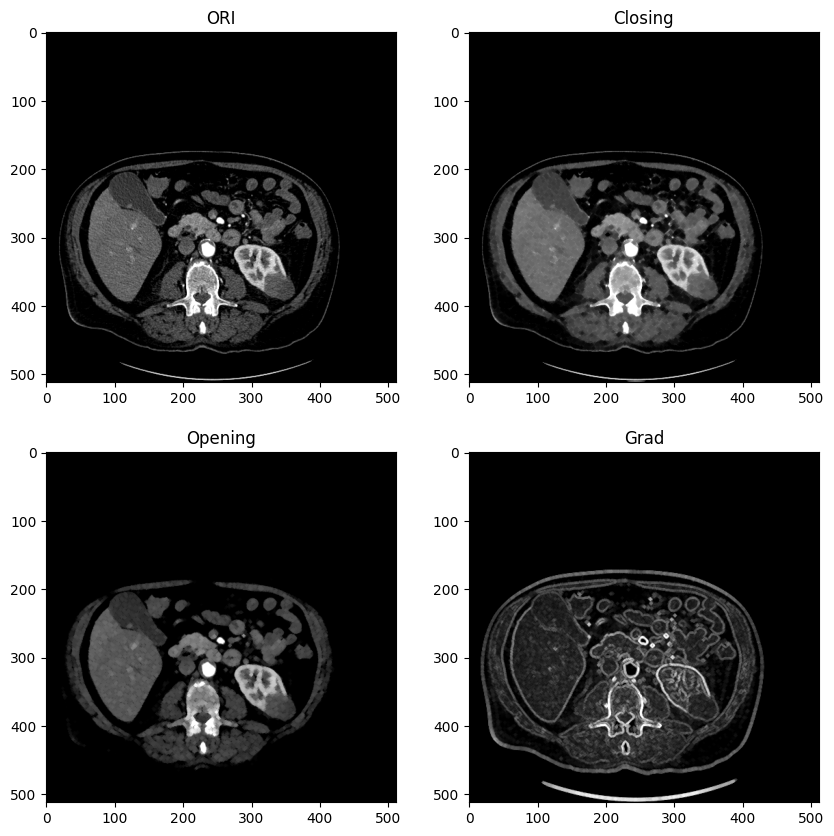

In [7]:
#Select input image
# img         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

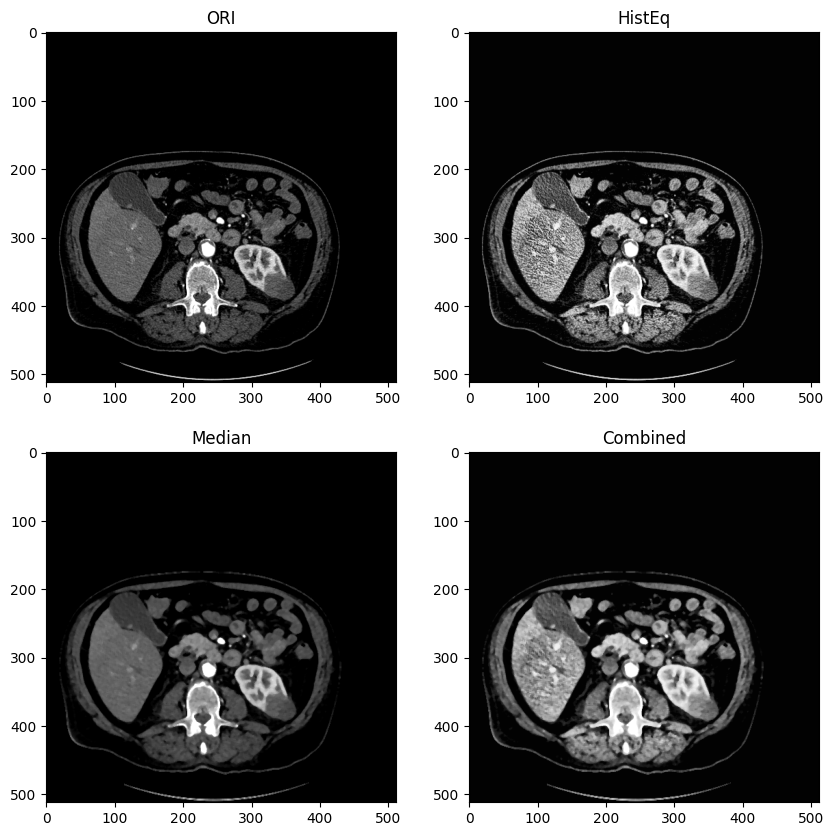

In [8]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



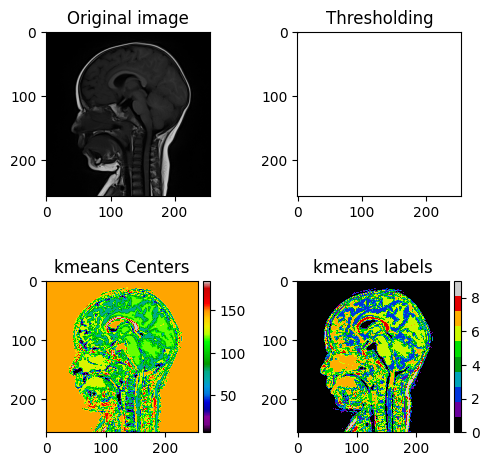

[  403.69919285 31121.57441253  8781.87235927 22870.18863362
 40610.21094641  3590.83068417 11126.57995307  6528.19538069
 15801.79866989 48967.38005644]


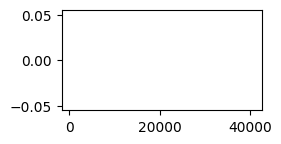

Yout Target_value =  5699
Distance of your Target_value to Centers =  [ 5296 25422  3083 17171 34911  2108  5427   829 10103 43268]
Your selected label (starting with 0)=  7


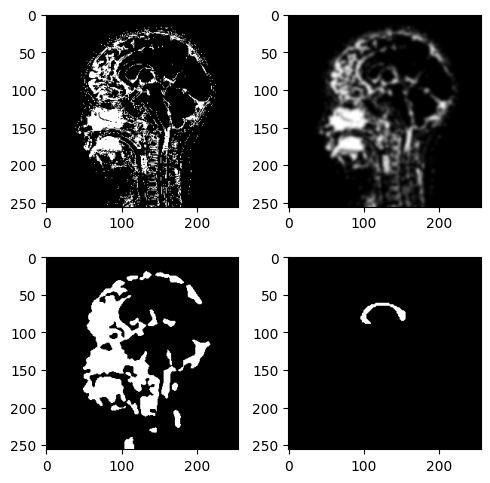

In [9]:
# Image use-case and HYPER-PARAMETER values provided as a good start

#Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_tumor_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()






## Extract the structure of interest from your segmentation mask

* CODE TO WRITE ON TWO EXAMPLES FROM SAME USE-CASE <br>
* RETURN A QUALITY METRIC ON THE SEGMENTATION PROVIDED BY YOU COMPARED TO THE PROVIDED GROUND TRUTH


---
#### **BRAIN IMAGES**

Lecture des images à disposition

In [10]:
nb_img = len(listImagesbrainMRI)
img_seg_set = [imread(listImagesbrainMRI[i]) for i in range (nb_img)]
img_set = [imread(listImagesbrainMRI[i][:-8] + '.png') for i in range (nb_img)]

In [11]:
for k in range (nb_img):
    img_set[k] = ((img_set[k]/np.max(img_set[k]))*255).astype(np.uint8)
    img_seg_set[k] =(img_seg_set[k]/np.max(img_seg_set[k])*255).astype(np.uint8)


In [12]:
img_bin_set = [0]*nb_img

for i in range (nb_img):
    assert img_seg_set[i].shape == img_set[i].shape, "Les masques et les images doivent avoir la même taille" 
    img_bin_set[i] = (img_seg_set[i]==255).astype('uint8')#transformation des masques en images binaires, plus faciles à manipuler pour des masques
    

Apprentissage des caractéristiques de la zone à segmenter

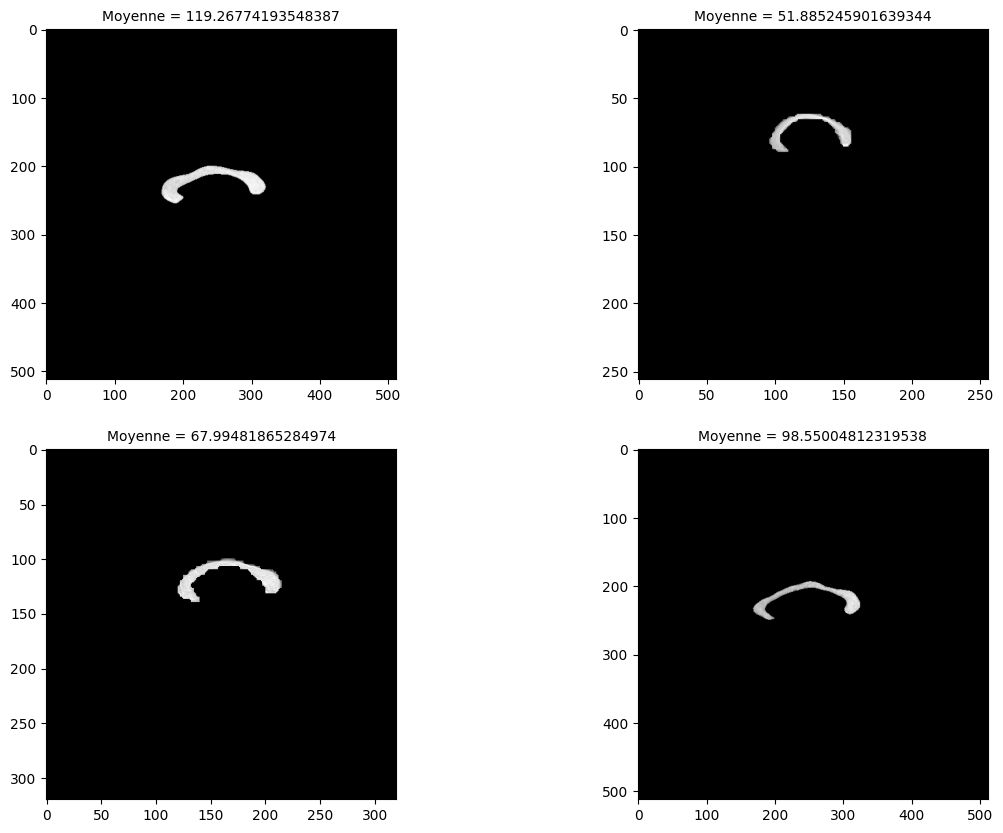

In [13]:
mean_list = np.array([0.0]*nb_img)

for k in range (nb_img):
    mean_list[k] = cv2.mean(img_set[k], img_bin_set[k])[0]

#visualisation des structures of interest

fig = plt.figure(figsize=(14,10))

fig.add_subplot(221).set_title('Moyenne = '+ str(mean_list[0]), fontsize='10' )
plt.imshow(img_seg_set[0]&img_set[0], cmap='gray')

fig.add_subplot(222).set_title('Moyenne = ' + str(mean_list[1]), fontsize='10' )
plt.imshow(img_seg_set[1]&img_set[1], cmap='gray')

fig.add_subplot(223).set_title('Moyenne = ' + str(mean_list[2]) , fontsize='10' )
plt.imshow(img_seg_set[2]&img_set[2], cmap='gray')

fig.add_subplot(224).set_title('Moyenne = ' + str(mean_list[3]) , fontsize='10' )
plt.imshow(img_seg_set[3]&img_set[3], cmap='gray')
    

> On remarque que selon l'image, la moyenne et l'écart-type de la zone a segmenter varient.  
En ajoutant un pre-processing, on pourra notamment uniformiser ces zones.

##### Pre_processing

In [14]:
def pre_proc(img):
    """pre traitement d'une image pour la segmentation"""
    img_pp = (skimage.exposure.equalize_adapthist(img)*255).astype(np.uint8) #egalisation d'histogramme
    img_pp = ndimage.median_filter(img, size=4)

    #operation(s) morphologique(s)

    se = disk(2)
    img_pp = morpho.closing(img_pp,se)

    return(img_pp)
 

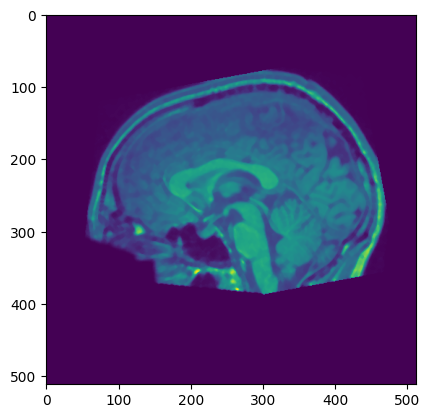

In [15]:
img_pp_set = [0,0,0,0]

for k in range(nb_img):
    img_pp_set[k] = pre_proc(img_set[k])

plt.imshow(img_pp_set[0])

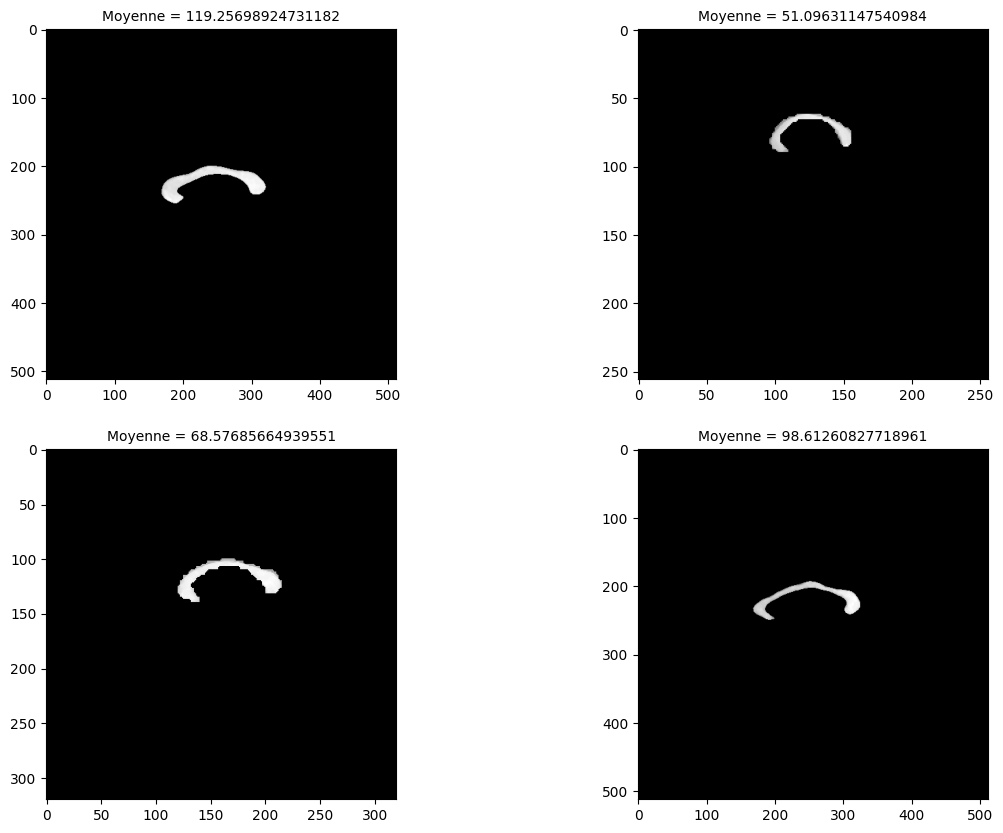

In [16]:
mean_list = np.array([0.0]*nb_img)

for k in range (nb_img):
    mean_list[k] = cv2.mean(img_pp_set[k], img_bin_set[k])[0]

#visualisation des structures of interest

fig = plt.figure(figsize=(14,10))

fig.add_subplot(221).set_title('Moyenne = '+ str(mean_list[0]), fontsize='10' )
plt.imshow(img_seg_set[0]&img_pp_set[0], cmap='gray')

fig.add_subplot(222).set_title('Moyenne = ' + str(mean_list[1]), fontsize='10' )
plt.imshow(img_seg_set[1]&img_pp_set[1], cmap='gray')

fig.add_subplot(223).set_title('Moyenne = ' + str(mean_list[2]) , fontsize='10' )
plt.imshow(img_seg_set[2]&img_pp_set[2], cmap='gray')

fig.add_subplot(224).set_title('Moyenne = ' + str(mean_list[3]) , fontsize='10' )
plt.imshow(img_seg_set[3]&img_pp_set[3], cmap='gray')
    

> Les écarts actuels de la moyenne entre les images 1 et 4 et les images 2 et 3 peuvent s'expliquer par la différence de qualité des deux groupes (valeurs comprises entre 0 et 255 ou non)

On peut également déterminer une approximation en nombre de pixels de la taille de la zone à segmenter.

In [17]:
size_list=[0]*nb_img

for k in range (nb_img):
    size_list[k]=(np.sum(img_bin_set[k]))

Travaillons sur la première image.

In [18]:
img_index = 0

img_orig = img_set[img_index]
img_seg = img_seg_set[img_index]
img_bin = img_bin_set[img_index]

mean = mean_list[img_index]
size = size_list[img_index]

img_pp = img_pp_set[img_index]

[ 72.79225306   0.15254123 120.71824271  33.02633303  86.10905991
  47.80890253  59.72544888 150.39303079  15.00627854 100.97681899]
Yout Target_value =  119
Distance of your Target_value to Centers =  [ 46 119   1  86  33  71  60  31 104  18]
Your selected label (starting with 0)=  2


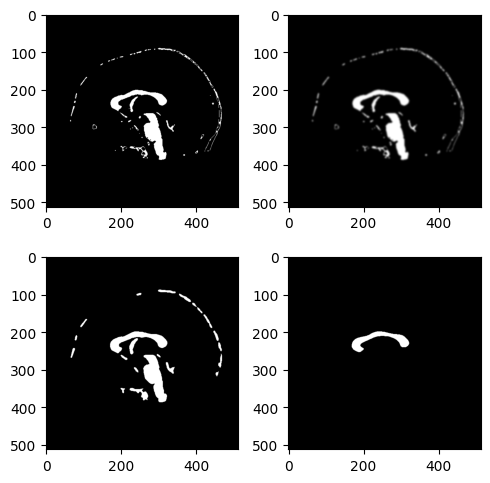

In [19]:
img=img_pp
nb_clusters = 10; 

Seg_km,Seg_km_labels = my_kmeans(img,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(img, Img_label_mask)
    Img_label_means[i] = tmp[0]
print(Img_label_means)

# Set a target intensity value and get the Kmeans label closest to it
Target_value = mean
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(img_seg, cmap='gray')

fig.tight_layout()
plt.show()






> On obtient une image avec plusieurs zones, dont celle à segmenter

##### POST PROCESSING

On se propose de ne conserver que la zone ayant la taille la plus proche en nombre de pixels de celle du modèle de masque.

In [20]:
x,y = Img_label_select_smooth_clean.shape
Img_label_select_smooth_clean = Img_label_select_smooth_clean.astype("uint8")
for i in range(x):
    for j in range(y):
        if Img_label_select_smooth_clean[i,j]:
            Img_label_select_smooth_clean[i,j]=255

On utilise des fonctions permettant de différencier les différentes régions, déjà implémentées en projet d'IMA201

In [21]:
def remplissage_region(I, u, v, label):
    """remplissage de la région dont fait partie le pixel (u,v) par la valeur label"""
    (l,L) = I.shape

    S = []
    S.append((u,v))
    while (S != []):
        (x,y) = S.pop()
        if (I[x][y]==255):
            I[x][y] = label
            if(x<l-1):
                S.append((x+1,y))
            if(y<L-1):
                S.append((x,y+1))
            if(y>0):
                S.append((x,y-1))
            if(x>0):
                S.append((x-1,y))
    return None

def marquage_regions(I):
    """séparation des zones blanches de l'image en différente régions"""
    (l,L) = I.shape
    m=2
    for u in range(l):
        for v in range(L):
            if (I[u][v]==255):
                remplissage_region(I,u,v,m)
                m += 1
    return I

def best_region(im_labeled, im_int):
    """choix de la région la meilleure d'après le critère du papier"""
    (l,L) = im_labeled.shape
    (x0,y0) = (l//2,L//2)
    sigx = sigy = 0.1*L
    N = [0]*(im_labeled.max()+1)
    for x in range(l):
        for y in range(L):
            i = im_labeled[x,y]
            N[i] += np.exp(-((x-x0)**2/(2*sigx**2)+(y-y0)**2/(2*sigy**2)))*im_int[x,y]

    index_best_region = N.index(max(N))

    im_final = np.where(im_labeled==index_best_region, 255,0)
    im_final = im_final.astype(np.uint8)
    return im_final


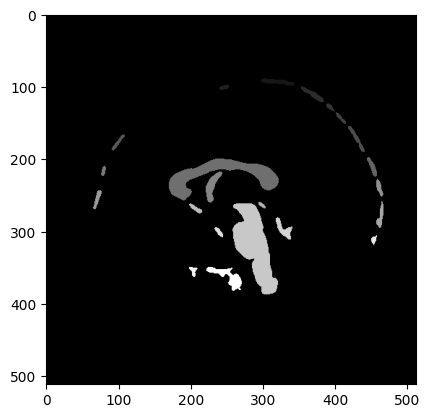

In [22]:
img_region = marquage_regions(Img_label_select_smooth_clean)
plt.imshow(img_region,cmap='gray')

In [23]:
nb_regions = np.max(img_region)
print(nb_regions)

23


In [24]:
sizes = [0,0]
for i in range(2,nb_regions):
    sizes.append(np.sum(Img_label_select_smooth_clean==i))

sizes = np.array(sizes) 
sizes = np.abs(sizes - size)

best_region_index = np.argmin(sizes)
img_final = Img_label_select_smooth_clean==best_region_index

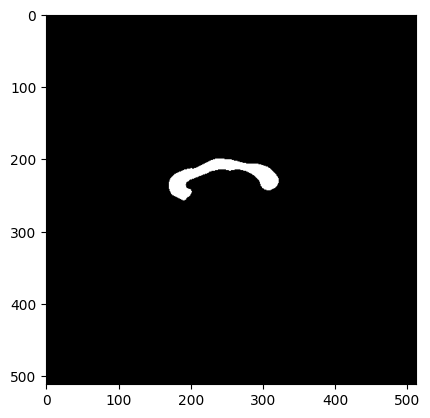

In [25]:
plt.imshow(img_final, cmap='gray')

#### Résultats

On quantifie le résultat obtenu avec un dice score

In [26]:
def dice_score(masque_th, masque_exp):
    """renvoie le dice score de deux masques"""
    inter = (masque_th & masque_exp) ^ ((1-masque_th) & (1-masque_exp))
    return np.sum(inter)/(masque_th.size)

In [27]:
print(dice_score(img_final, img_bin))

0.9986381530761719


> On obtient un dice_score très élevé, ce qui est peu étonnant puisque les paramètres utilisés pour l'étude sont exactement ceux du masque modèle.  
Cela montre quand même l'efficacité de la segmentation avec K-means

---
On essaye maintenant de répéter le même processus sur la 2e image.

In [28]:
img_index = 1

img_orig = img_set[img_index]
img_seg = img_seg_set[img_index]
img_bin = img_bin_set[img_index]

mean = mean_list[img_index]
size = size_list[img_index]

img_pp = img_pp_set[img_index]

[  1.18364607 110.35682327  53.67220077  24.62103342 182.59281437
  40.04795278  78.29274194  14.01243555 148.52112676  31.84065212]
Yout Target_value =  51
Distance of your Target_value to Centers =  [ 50  59   3  26 131  11  27  37  97  19]
Your selected label (starting with 0)=  2


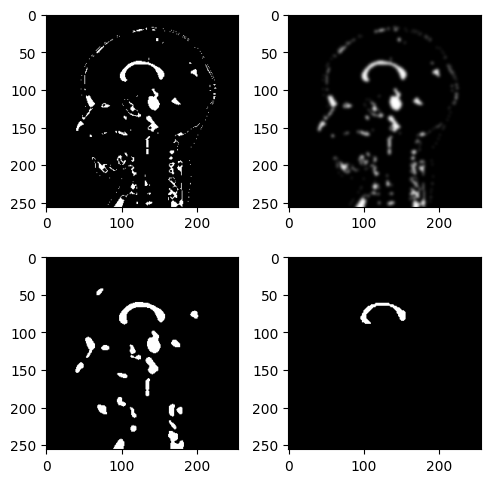

In [29]:
img=img_pp
nber_clusters = 10; 

Seg_km,Seg_km_labels = my_kmeans(img,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(img, Img_label_mask)
    Img_label_means[i] = tmp[0]
print(Img_label_means)

# Set a target intensity value and get the Kmeans label closest to it
Target_value = mean
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(img_seg, cmap='gray')

fig.tight_layout()
plt.show()






**POST PROCESSING**

In [30]:
x,y = Img_label_select_smooth_clean.shape
Img_label_select_smooth_clean = Img_label_select_smooth_clean.astype("uint8")
for i in range(x):
    for j in range(y):
        if Img_label_select_smooth_clean[i,j]:
            Img_label_select_smooth_clean[i,j]=255

In [31]:
def remplissage_region(I, u, v, label):
    """remplissage de la région dont fait partie le pixel (u,v) par la valeur label"""
    (l,L) = I.shape

    S = []
    S.append((u,v))
    while (S != []):
        (x,y) = S.pop()
        if (I[x][y]==255):
            I[x][y] = label
            if(x<l-1):
                S.append((x+1,y))
            if(y<L-1):
                S.append((x,y+1))
            if(y>0):
                S.append((x,y-1))
            if(x>0):
                S.append((x-1,y))
    return None

def marquage_regions(I):
    """séparation des zones blanches de l'image en différente régions"""
    (l,L) = I.shape
    m=2
    for u in range(l):
        for v in range(L):
            if (I[u][v]==255):
                remplissage_region(I,u,v,m)
                m += 1
    return I

def best_region(im_labeled, im_int):
    """choix de la région la meilleure d'après le critère du papier"""
    (l,L) = im_labeled.shape
    (x0,y0) = (l//2,L//2)
    sigx = sigy = 0.1*L
    N = [0]*(im_labeled.max()+1)
    for x in range(l):
        for y in range(L):
            i = im_labeled[x,y]
            N[i] += np.exp(-((x-x0)**2/(2*sigx**2)+(y-y0)**2/(2*sigy**2)))*im_int[x,y]

    index_best_region = N.index(max(N))

    im_final = np.where(im_labeled==index_best_region, 255,0)
    im_final = im_final.astype(np.uint8)
    return im_final


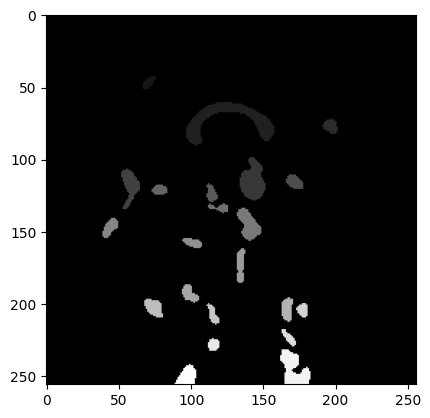

In [32]:
img_region = marquage_regions(Img_label_select_smooth_clean)
plt.imshow(img_region,cmap='gray')

In [33]:
nb_regions = np.max(img_region)
print(nb_regions)

23


In [34]:
sizes = [0,0]
for i in range(2,nb_regions):
    sizes.append(np.sum(Img_label_select_smooth_clean==i))

sizes = np.array(sizes) 
sizes = np.abs(sizes - size)

best_region_index = np.argmin(sizes)
img_final = Img_label_select_smooth_clean==best_region_index

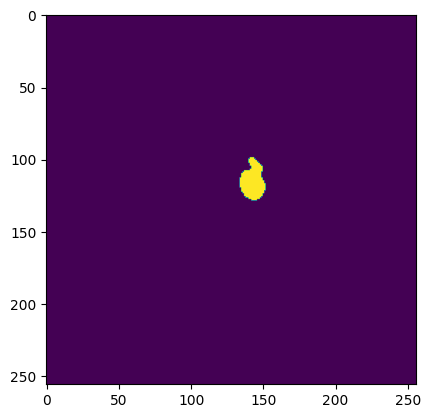

In [35]:
plt.imshow(img_final)

In [36]:
print(dice_score(img_final, img_bin))

0.9870147705078125


> Le code proposé fonctionne toujours pour cette deuxième image  
On obtient à nouveau un dice score très élevé, qui montre la qualité de la méthode de segmentation.
